In [1]:
%matplotlib inline

# Skeletonization Notebook

### Prepare the environment

In [6]:
from skimage import morphology
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
from tabulate import tabulate

### Load images

A subset of 10 binary images was taken from [LIA website](http://lia.esei.uvigo.es/thinning_gallery/) to carry out the experiments and saved into `./images`.

images/8xm4_preprocess_SIMPLE_RU.png
(112, 398)


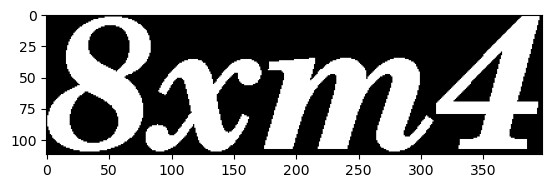

images/alpert_preprocess_SIMPLE_RU.png
(849, 679)


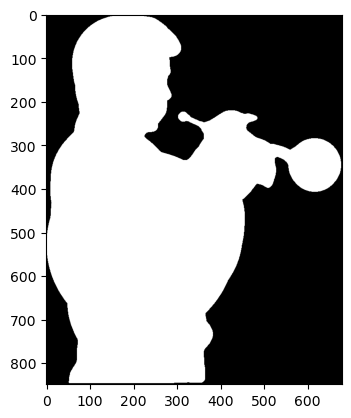

images/bat_preprocess_SIMPLE_RU.png
(759, 2002)


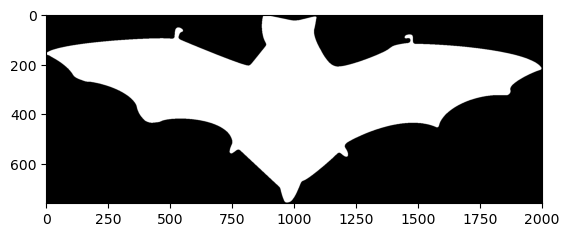

images/bridge_preprocess_SIMPLE_RU.png
(205, 481)


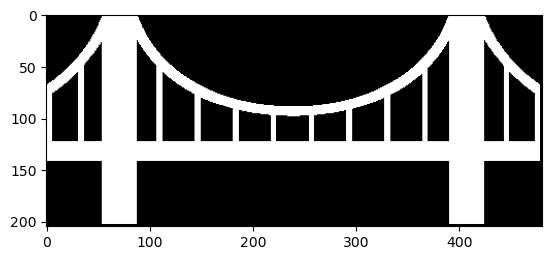

images/butterfly.png
(413, 612)


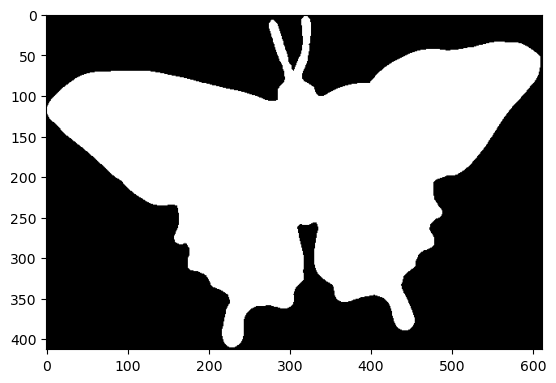

images/eagle2_preprocess_SIMPLE_RU.png
(720, 604)


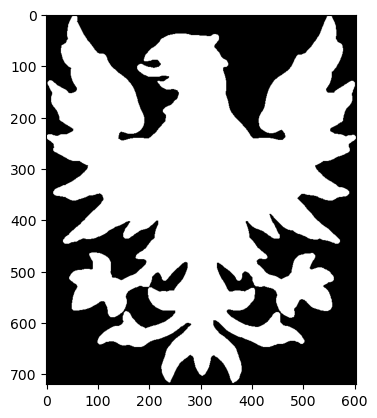

images/hand_preprocess_SIMPLE_RU.png
(1113, 933)


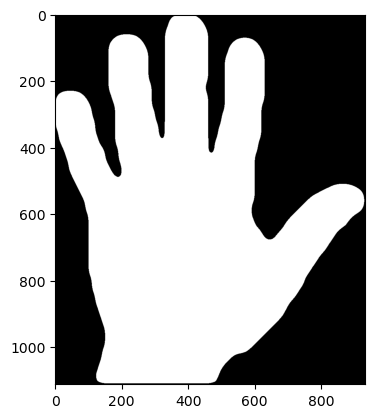

images/leaf2_preprocess_SIMPLE_RU.png
(678, 609)


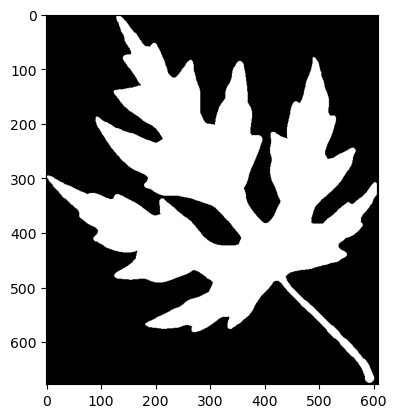

images/profile_preprocess_SIMPLE_RU.png
(1090, 690)


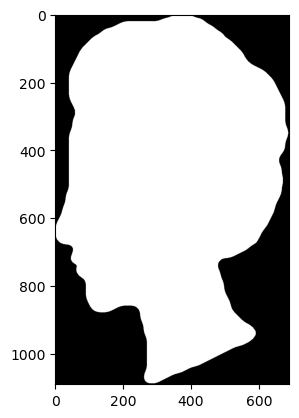

images/tennisplayer_preprocess_SIMPLE_RU.png
(2052, 1822)


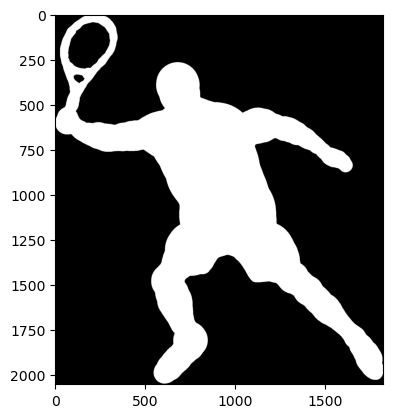

In [4]:
# Load visualize all images
def load_images(folder):
    images_path = glob.glob(folder + '/*.png')
    images = [plt.imread(image) for image in images_path]
    for path,image in zip(images_path,images):
        print(path)
        print(image.shape)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.show()
    return images

images = load_images('images')

## 1. Skeletonize images

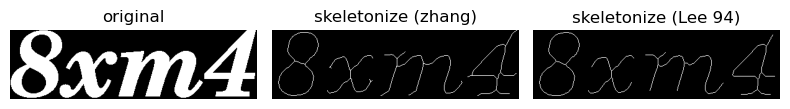

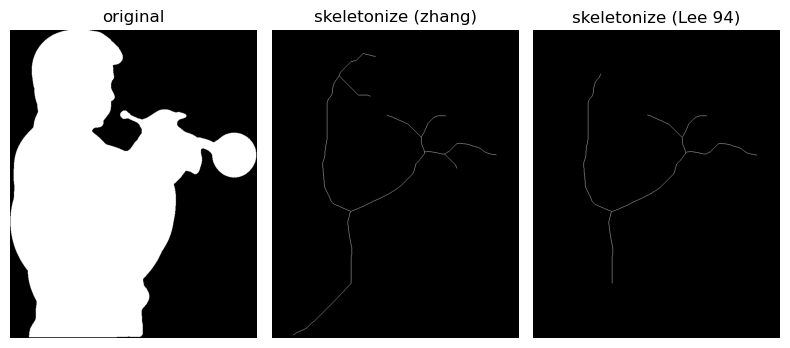

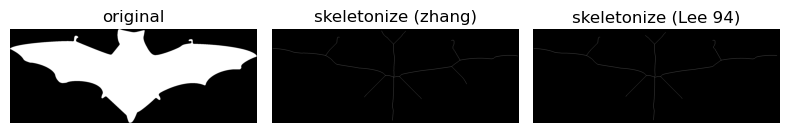

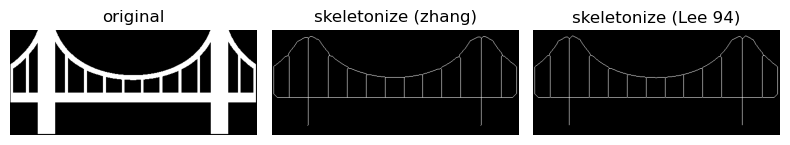

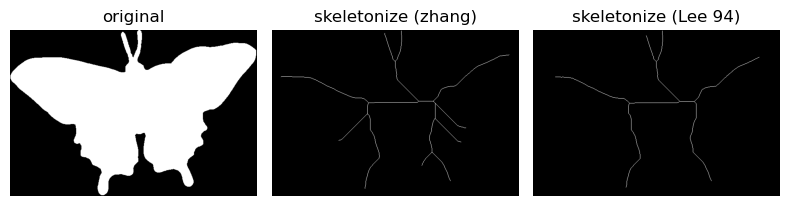

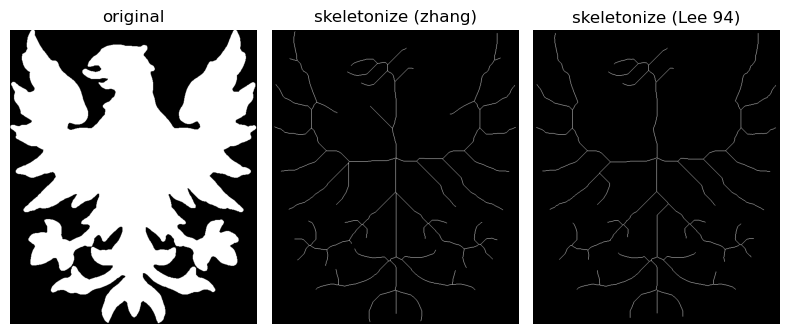

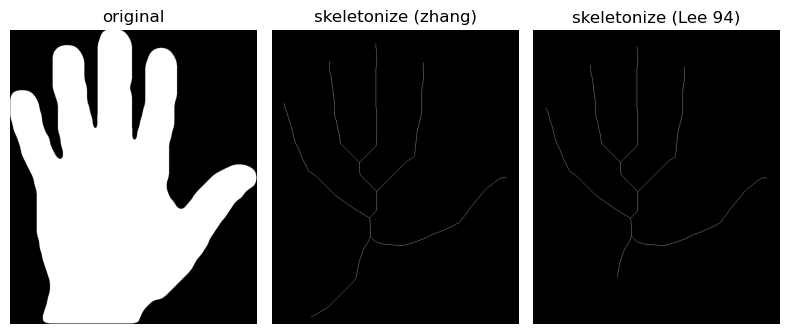

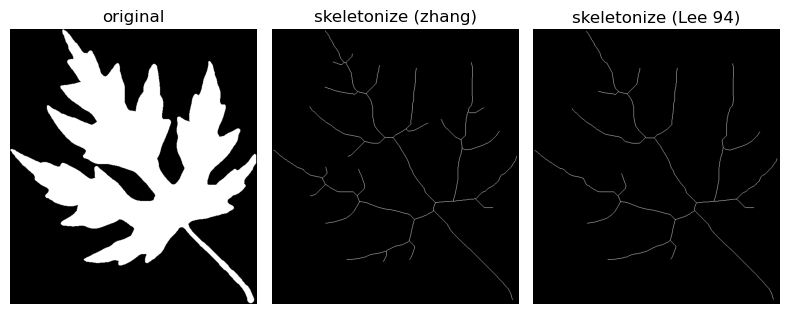

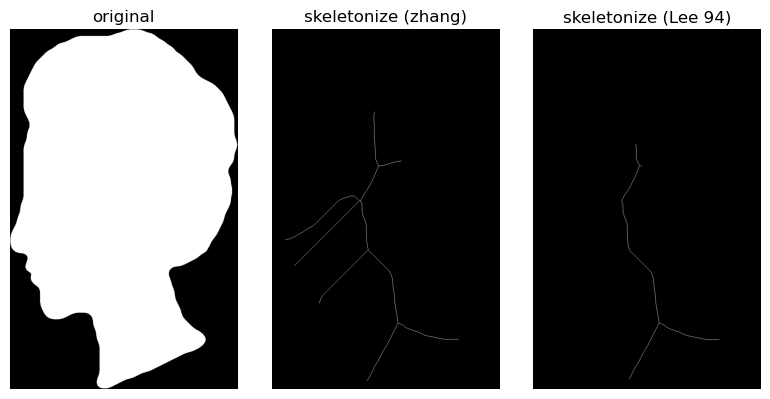

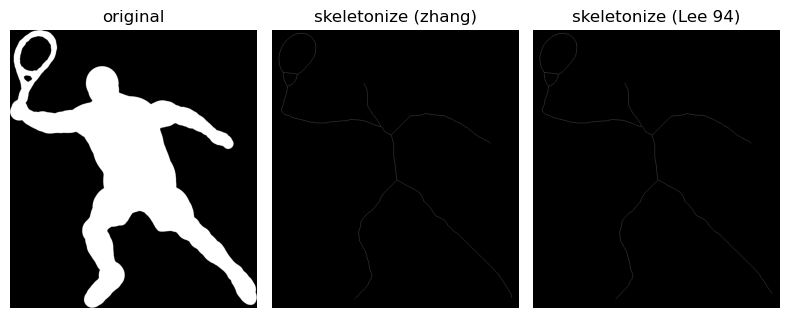

In [7]:
def skeletonize_images(images, method="zhang"):
    skeletons = [skeletonize(image, method=method).astype("uint8") for image in images]

    # Convert 255 values into 1 (problem with lee skeleton)
    for skeleton in skeletons:
        skeleton[skeleton == 255] = 1 
    
    return skeletons

skeletons = skeletonize_images(images, method="zhang")
skeletons_lee = skeletonize_images(images, method="lee")

for image, skeleton, skeleton_lee in zip(images,skeletons,skeletons_lee):
    fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[0].axis('off')

    ax[1].imshow(skeleton, cmap=plt.cm.gray)
    ax[1].set_title('skeletonize (zhang)')
    ax[1].axis('off')

    ax[2].imshow(skeleton_lee, cmap=plt.cm.gray)
    ax[2].set_title('skeletonize (Lee 94)')
    ax[2].axis('off')

    fig.tight_layout()
    plt.show()

Looking at the images above we can perceive **some differences** among the skeletons generated by the two different methods. Lee-generated skeletons tend to have shorter branches than Zhang-generated ones.

## Prepare metrics

Performance evaluation of a skeletonization algorithm is a serious research challenge emerging from the lack of definition of the "true" skeleton for a digital object. Therefore, a widely accepted approach evaluating the performance of a skeletonization algorithm is yet absent in the literature. For the aim of deciding which algorithm is better several metrics have been proposed:
- Reconstruction error
- Approximation of the medial axis
- Invariance to similarity transformation
- Coverage of true medial axis
- Unit-width, irreducibility
- Graph analysis: number of end points, number of T-points, number of X-points
- Skeleton size (number of pixels of the skeleton)
- Skeleton length (sum of distance between neighboring pixel along paths)
- Ratio of skeleton size to skeleton length
- Approximation of end points to the border of the shape

Just for a sanity check, below we perform some initial experiments to guarantee our metrics code work as intended.

### Image reconstruction

Image reconstruction from skeleton


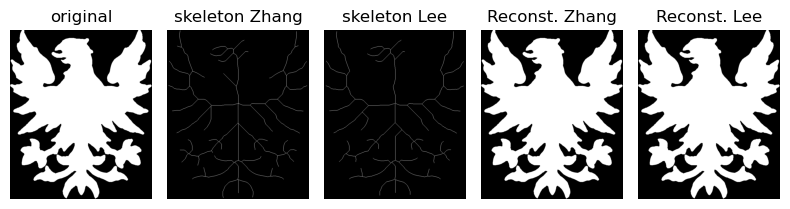

In [74]:
## Image reconstruction from skeleton
original_image, skeleton, skeleton_lee = images[5],skeletons[5],skeletons_lee[5]

# Compute the medial axis
medial_axis_image, distance_map = medial_axis(original_image, return_distance=True)

# Reconstruction error
reconstructed_image = morphology.reconstruction(skeleton, distance_map)
reconstructed_image_lee = morphology.reconstruction(skeleton_lee, distance_map)

print("Image reconstruction from skeleton")
fig, axes = plt.subplots(1, 5, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(original_image, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeleton Zhang')
ax[1].axis('off')

ax[2].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[2].set_title('skeleton Lee')
ax[2].axis('off')

ax[3].imshow(reconstructed_image, cmap=plt.cm.gray)
ax[3].set_title('Reconst. Zhang')
ax[3].axis('off')

ax[4].imshow(reconstructed_image_lee, cmap=plt.cm.gray)
ax[4].set_title('Reconst. Lee')
ax[4].axis('off')

fig.tight_layout()
plt.show()

### Coverage of true medial axis

Coverage of true medial axis


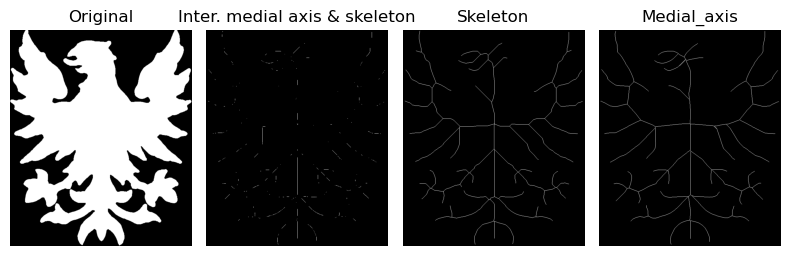

In [75]:
print("Coverage of true medial axis")

fig, axes = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(original_image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(medial_axis_image & skeleton, cmap=plt.cm.gray)
ax[1].set_title('Inter. medial axis & skeleton')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('Skeleton')
ax[2].axis('off')

ax[3].imshow(medial_axis_image, cmap=plt.cm.gray)
ax[3].set_title('Medial_axis')
ax[3].axis('off')

fig.tight_layout()
plt.show()

## Compute metrics 

As said previously below the implementation for the selected metrics is shown:
- Reconstruction error
- Topology preservation (euler number)
- Approximation of the medial axis
- Invariance to similarity transformation
- Coverage of true medial axis
- Unit-width, irreducibility
- Graph analysis: number of end points, number of T-points, number of X-points
- Skeleton size (number of pixels of the skeleton)
- Skeleton length (sum of distance between neighboring pixel along paths)
- Ratio of skeleton size to skeleton length
- Approximation of end points to the border of the shape

In [25]:
from skimage.measure import label, regionprops, find_contours
from skimage.morphology import medial_axis
from scipy.spatial import distance

def find_endpoints(skeleton):
    # Define structural element for neighborhood
    selem = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]])

    # Count neighbors for each pixel in the skeleton
    num_neighbors = morphology.binary_erosion(skeleton, selem) * morphology.binary_dilation(skeleton, selem)

    # Endpoints are pixels with exactly one neighbor
    endpoints = np.logical_and(skeleton, num_neighbors == 1)
    return endpoints

def euler_number(binary_image, skeleton):
    """
    The Euler number is a topological invariant that provides information about the connectivity and shape of an object in an image. For binary images, it can be calculated as:

    𝜒 = number of connected components - number of holes
    
    where:

    "number of connected components" represents the number of distinct regions or objects in the binary image.
    "number of holes" refers to the number of enclosed regions within the object.

    A perfectly preserved topology would have the same Euler number for both the original image and its skeleton.
    """
    # Perform connectivity analysis on the original image and its skeleton
    original_labels = morphology.label(binary_image)
    skeleton_labels = morphology.label(skeleton)

    # Count the number of connected components and holes
    num_original_components = np.max(original_labels)
    num_skeleton_components = np.max(skeleton_labels)
    num_holes = num_original_components - num_skeleton_components

    # Calculate Euler number
    euler_num = num_original_components - num_holes
    return euler_num

def compute_skeleton_length(skeleton):
    """
    Calculate the Euclidean distance transform of the skeletonized image to compute the distances between neighboring pixels.
    Then sum up these distances to get the skeleton length.
    """ 
    # Compute the Euclidean distance transform of the skeleton
    distance_transform = distance_transform_edt(skeleton)

    # Get the coordinates of skeleton pixels
    skeleton_indices = np.transpose(np.nonzero(distance_transform))

    # Initialize skeleton length
    skeleton_length = 0

    # Iterate over each skeleton pixel
    for x, y in skeleton_indices:
        # Get the neighboring pixels of the current skeleton pixel
        neighbors = [
            (x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1),                 (x, y + 1),
            (x + 1, y - 1), (x + 1, y), (x + 1, y + 1)
        ]

        # Compute the distance between the current pixel and its neighbors
        for nx, ny in neighbors:
            if 0 <= nx < skeleton.shape[0] and 0 <= ny < skeleton.shape[1]:
                if skeleton[nx, ny]:
                    # Euclidean distance between skeleton pixels
                    skeleton_length += np.sqrt((x - nx) ** 2 + (y - ny) ** 2)

    return skeleton_length

def analyze_graph(skeleton):

    # Get the coordinates of skeleton pixels
    skeleton_indices = np.transpose(np.nonzero(skeleton))

    # Initialize counts for end points, T-points, and X-points
    end_points = []
    num_t_points = 0
    num_x_points = 0

    # Iterate over each skeleton pixel
    for x, y in skeleton_indices:
        # Get the neighboring pixels of the current skeleton pixel
        neighbors = [
            (x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1),                 (x, y + 1),
            (x + 1, y - 1), (x + 1, y), (x + 1, y + 1)
        ]

        # Count the number of foreground neighbors
        foreground_neighbors = sum(skeleton[nx, ny] for nx, ny in neighbors)

        # Depending on the number of foreground neighbors, classify the pixel
        if foreground_neighbors == 1:
            end_points.append((x,y))
        elif foreground_neighbors == 3:
            num_t_points += 1
        elif foreground_neighbors == 4:
            num_x_points += 1

        end_points

    return end_points, num_t_points, num_x_points

def compute_metrics(original_image, skeleton):
    # Compute the medial axis
    medial_axis_image, distance_map = medial_axis(original_image, return_distance=True)
    
    # Reconstruction error
    reconstructed_image = morphology.reconstruction(skeleton, distance_map)
    reconstruction_error = np.sum(original_image != reconstructed_image) / original_image.size
    
    # Topology preservation
    # Calculate Euler characteristics
    euler = euler_number(original_image,skeleton)
    
    # Approximation of the medial axis
    medial_axis_approximation = np.sum(skeleton) / np.sum(medial_axis_image)
    
    # Invariance to similarity transformation
    # This metric can be subjective and depends on how similarity transformation is defined.
    # Generally, skeletonization is invariant to translation, rotation, and uniform scaling.
    # You may need to define a specific similarity transformation to measure this metric.

    # Coverage of true medial axis
    true_medial_axis_coverage = np.sum(skeleton & medial_axis_image) / np.sum(medial_axis_image)
    
    # Unit-width, irreducibility
    # Unit-width: This might require additional processing to identify branches and measure their width
    # Irreducibility: Skeleton is often considered irreducible, as removing any pixel would disconnect it.
    
    # Label connected components in the skeleton
    end_points, num_t_points, num_x_points = analyze_graph(skeleton)
    
    # Skeleton size (number of pixels of the skeleton)
    skeleton_size = np.sum(skeleton)
    
    # Skeleton length (sum of distance between neighboring pixel along paths)
    #skeleton_length = 0
    skeleton_length = compute_skeleton_length(skeleton)
    
    # Ratio of skeleton size to skeleton length
    if skeleton_length != 0:
        skeleton_size_to_length_ratio = skeleton_size / skeleton_length
    else:
        skeleton_size_to_length_ratio = np.nan
    
    # Approximation of end points to the border of the shape
    #border_distance = distance_transform_edt(original_image == 0)
    #mean_distance_to_border = np.mean(border_distance[end_points])
    
    return {
        "reconstruction_error": reconstruction_error,
        "euler_number": euler,
        "approximation_of_the_medial_axis": medial_axis_approximation,
        #"invariance_to_similarity_transformation": "Depends on definition",
        "coverage_of_true_medial_axis": true_medial_axis_coverage,
        #"unit_width_irreducibility": "Needs additional computation",
        "num_end_points": len(end_points),
        "num_t_points": num_t_points,
        "num_x_points": num_x_points,
        "skeleton_size": skeleton_size,
        "skeleton_length": skeleton_length,
        "skeleton_size_to_length_ratio": skeleton_size_to_length_ratio
        #"appearance_of_small_branches": "Needs additional analysis",
        #"approximation_of_end_points_to_border": mean_distance_to_border
    }

{'reconstruction_error': 0.0, 'euler_number': 4, 'approximation_of_the_medial_axis': 0.9375, 'coverage_of_true_medial_axis': 0.4606164383561644, 'num_end_points': 16, 'num_t_points': 40, 'num_x_points': 11, 'skeleton_size': 1095, 'skeleton_length': 2627.846030004912, 'skeleton_size_to_length_ratio': 0.4166910798795747}


(-0.5, 397.5, 111.5, -0.5)

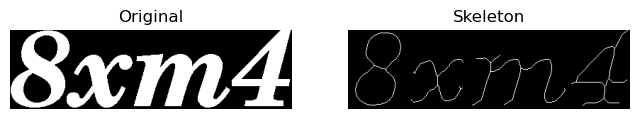

In [26]:
# Example metrics computation
print(compute_metrics(images[0],skeletons[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(images[0], cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(skeletons[0], cmap=plt.cm.gray)
ax[1].set_title('Skeleton')
ax[1].axis('off')

Let's compute the metrics for all the generated skeletons with both Zhang and Lee methods.

In [27]:
# Initialize a dictionary to store the sum of values for each key
metrics_skeleton = pd.DataFrame()
metrics_skeleton_lee = pd.DataFrame()

for image, skeleton, skeleton_lee in zip(images,skeletons,skeletons_lee):
    metrics_skeleton = pd.concat([metrics_skeleton, pd.DataFrame.from_records([compute_metrics(image,skeleton)])])
    metrics_skeleton_lee = pd.concat([metrics_skeleton_lee, pd.DataFrame.from_records([compute_metrics(image,skeleton_lee)])])

print(metrics_skeleton.describe())

       reconstruction_error  euler_number  approximation_of_the_medial_axis  \
count                  10.0     10.000000                         10.000000   
mean                    0.0      1.300000                          1.006922   
std                     0.0      0.948683                          0.062820   
min                     0.0      1.000000                          0.934300   
25%                     0.0      1.000000                          0.969865   
50%                     0.0      1.000000                          0.989368   
75%                     0.0      1.000000                          1.022002   
max                     0.0      4.000000                          1.145329   

       coverage_of_true_medial_axis  num_end_points  num_t_points  \
count                     10.000000       10.000000     10.000000   
mean                       0.232906       13.000000     36.400000   
std                        0.199269       12.613925     31.475564   
min         

In [28]:
print(metrics_skeleton_lee.describe())

       reconstruction_error  euler_number  approximation_of_the_medial_axis  \
count                  10.0     10.000000                         10.000000   
mean                    0.0      1.300000                          0.864675   
std                     0.0      0.948683                          0.108685   
min                     0.0      1.000000                          0.626648   
25%                     0.0      1.000000                          0.850693   
50%                     0.0      1.000000                          0.888738   
75%                     0.0      1.000000                          0.920019   
max                     0.0      4.000000                          1.007277   

       coverage_of_true_medial_axis  num_end_points  num_t_points  \
count                     10.000000       10.000000     10.000000   
mean                       0.218497       10.100000     18.500000   
std                        0.204758       10.311267     19.190565   
min         

In [29]:
# Compute descriptive statistics for each feature in both DataFrames
statistics_df1 = metrics_skeleton.describe().loc[['mean', 'std']].transpose()
statistics_df2 = metrics_skeleton_lee.describe().loc[['mean', 'std']].transpose()

# Combine descriptive statistics into a single DataFrame
comparison_table = pd.concat([statistics_df1, statistics_df2], axis=1, keys=['Zhang', 'Lee'])

# Format the DataFrame into a comparison table using tabulate
table = tabulate(comparison_table, headers=['Metric', 'Zhang (mean)', 'Zhang (std)', 'Lee (mean)', 'Lee (std)'], tablefmt='grid')

print(table)

+----------------------------------+----------------+---------------+--------------+--------------+
| Metric                           |   Zhang (mean) |   Zhang (std) |   Lee (mean) |    Lee (std) |
+==================================+================+===============+==============+==============+
| reconstruction_error             |       0        |     0         |     0        |    0         |
+----------------------------------+----------------+---------------+--------------+--------------+
| euler_number                     |       1.3      |     0.948683  |     1.3      |    0.948683  |
+----------------------------------+----------------+---------------+--------------+--------------+
| approximation_of_the_medial_axis |       1.00692  |     0.0628204 |     0.864675 |    0.108685  |
+----------------------------------+----------------+---------------+--------------+--------------+
| coverage_of_true_medial_axis     |       0.232906 |     0.199269  |     0.218497 |    0.204758  |


Comparing the Zhang and Lee skeletonization methods based on the previous metrics reveals some interesting insights. Both methods show a null reconstruction error, indicating their effectiveness in preserving the structure of the original binary image. In addition, Euler numbers coincide indicating the same topology preservation for both algorithms. However, there are differences in approximation of the medial axis. Zhang's method slightly outperforms Lee's method in terms of coverage of the true medial axis, suggesting that Zhang's method better maintains the connectivity and shape of objects in the binary image. 

Additionally, Zhang's method produces skeletons with more end points, T-points, and X-points compared to Lee's method, indicating that Zhang's method may capture finer details and junctions in the image. However, Lee's method generates skeletons with a slightly smaller skeleton size and length, suggesting that it may produce more compact representations of objects in the image.

Overall, the choice between the two methods depends on the specific requirements of the application, with Zhang's method offering better topology preservation and junction detection, while Lee's method providing more compact skeletons.

### Properties guaranteed by each algorithm

**Zhang**'s method paper states that for extracting the skeleton of a picture consists of removing all the contour points of the picture except those points that belong to the skeleton. In order to preserve the connectivity of the skeleton, it divides each iteration into two subiterations.

In the first subiteration, the contour point P1 is deleted from the digital pattern if it satisfies the following conditions:

- (a) 2 ≤ B(P1) ≤ 6
- (b) A(P1) = 1
- (c) P2*P4*P6 = 0
- (d) P4*P6*P8 = 0 

By condition (a), the **endpoints** of a skeleton line are **preserved**. Also, condition (b) **prevents the deletion** of those points that lie **between the endpoints** of a skeleton line. The execution time depends on the complexity of the pattern and the thickness of the strokes.

**Lee**'s method paper states that its implementation contains a series of constraints to guarantee the preservation of the topological and the geometrical conditions.

Each skeletonization method has its own set of properties and guarantees, although none of them can fulfill all possible criteria perfectly. Here's a breakdown of the properties typically associated with each method:

- Zhang's method:
    - **Connectivity Preservation**
    - **Topological Preservation**
    - **Simplicity**
- Lee's method:
    - **Branch Reduction**
    - **Topology Preservation**
    - **Shape preservation**
    - **Connectivity Preservation**

## 2. Visualize the distance transform as computed by skimage and compare to the other distance metrics as available in the OpenCV package

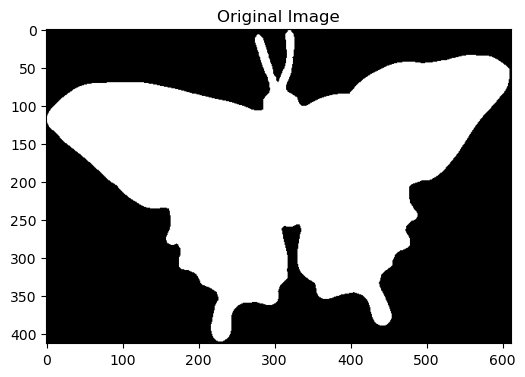

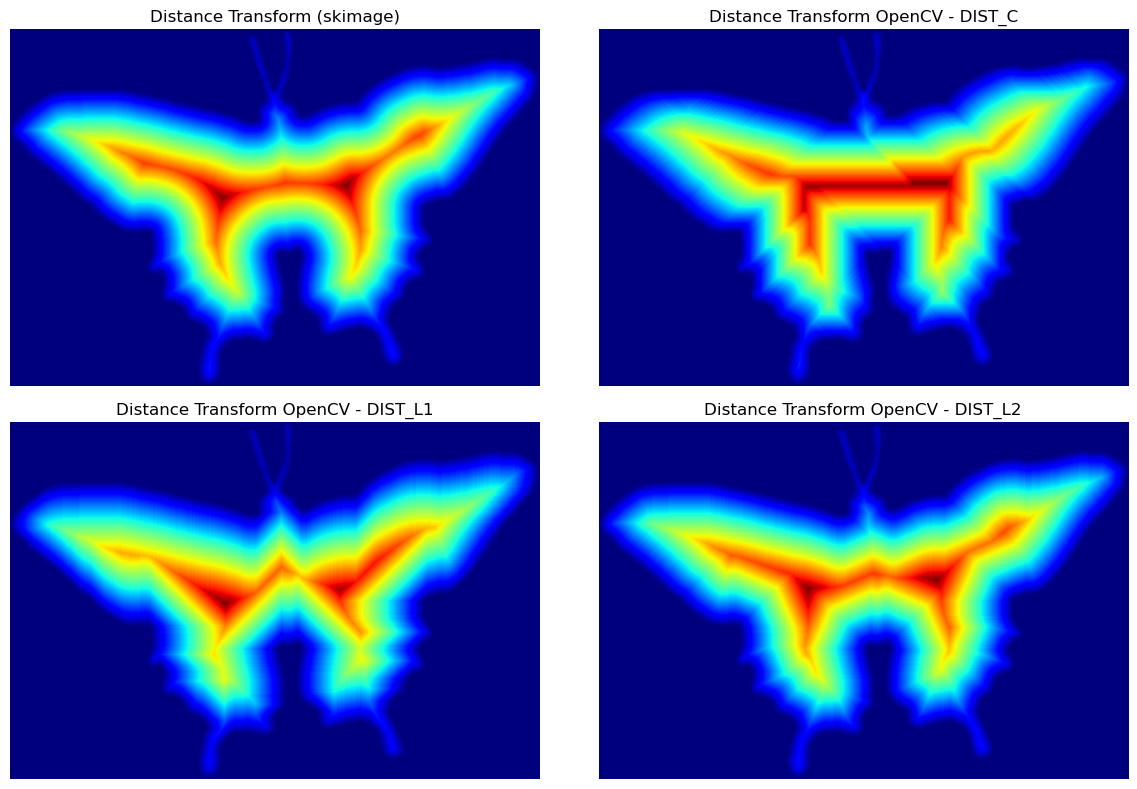

In [82]:
image = cv2.imread('images/butterfly.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.show()

distTransform_skimage = distance_transform_edt(gray)

distTransform_c = cv2.distanceTransform(gray, cv2.DIST_C, 3)
distTransform_l1 = cv2.distanceTransform(gray, cv2.DIST_L1, 3)
distTransform_l2 = cv2.distanceTransform(gray, cv2.DIST_L2, 3)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].imshow(distTransform_skimage, cmap='jet')
axes[0, 0].set_title('Distance Transform (skimage)')
axes[0, 0].axis('off')

axes[0, 1].imshow(distTransform_c, cmap='jet')
axes[0, 1].set_title('Distance Transform OpenCV - DIST_C')
axes[0, 1].axis('off')

axes[1, 0].imshow(distTransform_l1, cmap='jet')
axes[1, 0].set_title('Distance Transform OpenCV - DIST_L1')
axes[1, 0].axis('off')

axes[1, 1].imshow(distTransform_l2, cmap='jet')
axes[1, 1].set_title('Distance Transform OpenCV - DIST_L2')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Change the visualization of the OpenCV result to run in matplotlib

In [83]:
import cv2

image = cv2.imread(r"images/butterfly.png")

# convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow('Image', gray)
#cv2.waitKey(0)
# if not already binary
#_, threshold = cv2.threshold(gray, 123, 255, cv2.THRESH_BINARY)

# calculate the distance transform, possible metrics...
# distTransform = cv2.distanceTransform(threshold, cv2.DIST_C, 3)
# distTransform = cv2.distanceTransform(threshold, cv2.DIST_L1, 3)
distTransform= cv2.distanceTransform(gray, cv2.DIST_L2, 3)
#cv2.imwrite('distTransformed.png',distTransform)
dtimage = cv2.imread(r"distTransformed.png")
#cv2.imshow('Transformed Distance Image', dtimage)
#cv2.waitKey(0)

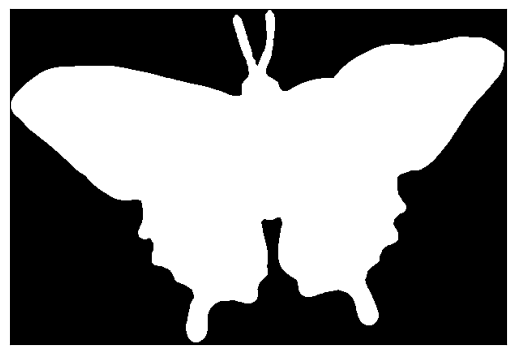

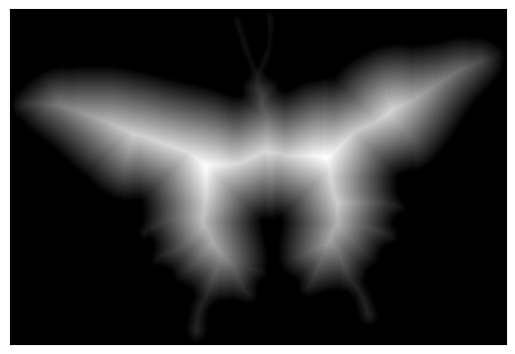

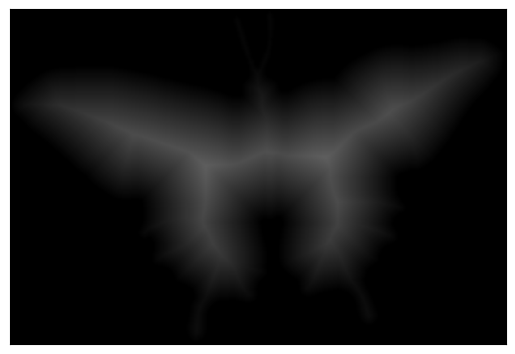

In [84]:
def cv2_to_plt(image): # for color images
    b,g,r = cv2.split(image)       # get b,g,r
    image = cv2.merge([r,g,b])     # switch it to rgb
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #alternatively...

    #image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    return image

#distTransform = cv2_to_plt(distTransform)
#dtimage = cv2_to_plt(dtimage)

plt.imshow(gray,cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(distTransform,cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(dtimage,cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()